In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

In [2]:
import warnings
# suppress warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# Basics
import os
import sys
import time
import numpy as np
import pandas as pd
import csv
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm
from ssms.basic_simulators.simulator import simulator

# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# Setting float precision in pytensor
pytensor.config.floatX = "float32"

import jax
jax.config.update("jax_enable_x64", False)

import src.utils.setup_figures as figures
import src.utils.basic as utils


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
from config import dir_config, main_config

base_data_dir = Path(dir_config.data.base)
raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)

data = pd.read_csv(Path(processed_dir, "processed_data60accu_allowed.csv"), index_col=None)
processed_metadata = pd.read_csv(Path(processed_dir, "processed_metadata_60accu_allowed.csv"), index_col=None)

# exclude the following subjects where categorization score is more than 2
reject_subs = processed_metadata.loc[processed_metadata["categorization_score"] > 2]['subject_id']
processed_metadata = processed_metadata.loc[~processed_metadata["subject_id"].isin(reject_subs)]
processed_data = data.loc[~data["subject"].isin(reject_subs)]


## Model

In [4]:
processed_data.head()

,subject,medication,prior,prior_direction,prior_color,color,coherence,target,is_valid,outcome,choice,reaction_time,session_name,signed_coherence
0,CG,off,rl,left,red,1,100.0,1,True,True,1,626.976669,Brady_CG_OFFmeds_rl.mat,100.0
1,CG,off,rl,left,red,-1,0.0,1,True,False,-1,945.801775,Brady_CG_OFFmeds_rl.mat,0.0
2,CG,off,rl,left,red,-1,0.0,-1,True,False,1,964.249405,Brady_CG_OFFmeds_rl.mat,-0.0
3,CG,off,rl,left,red,-1,100.0,-1,True,True,-1,671.215080,Brady_CG_OFFmeds_rl.mat,-100.0
4,CG,off,rl,left,red,-1,0.0,1,True,True,1,1046.959465,Brady_CG_OFFmeds_rl.mat,0.0


### Loading Dataset

processed_data  
&ensp;&ensp;color: &ensp;&ensp;&ensp;&ensp;&ensp;{prior: 1, equal: -1}  
&ensp;&ensp;direction: &ensp;&ensp;{prior: 1, equal: -1}

In [ ]:
model_data = pd.DataFrame(
    {
        "rt": processed_data["reaction_time"]/1000,
        "response": processed_data["choice"],
        "stimulus": processed_data["signed_coherence"]/100,
        "color": processed_data["color"].astype("category"),
        "treatment": processed_data["medication"].replace({"off": 0, "on": 1}).astype("category"),
        "subject": processed_data["subject"],
    }
)

In [6]:
subjects = processed_metadata["subject_id"].values


Model initialized successfully.


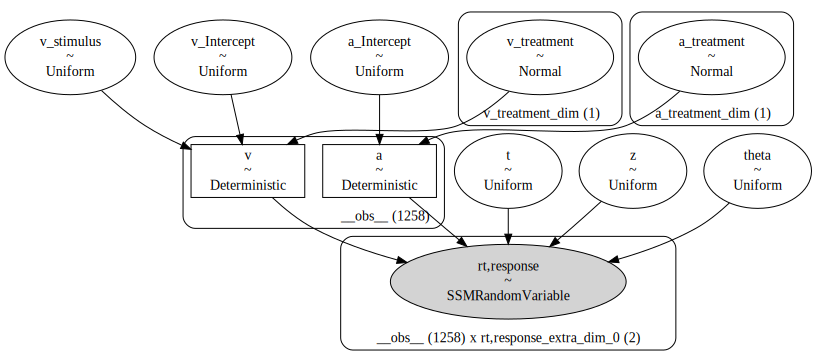

In [7]:
model_reg_v_a = hssm.HSSM(
    data=model_data.loc[model_data["subject"] == subjects[0]],
    model="angle",
    include = [
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "stimulus":  {"name": "Uniform", "lower": -3.0, "upper": 3.0},
            },
            "formula": "v ~ stimulus + treatment",
            "link": "identity",
            
        },
        {
            "name": "a",
            "prior": {"Intercept": {"name": "Uniform", "lower": 0.5, "upper": 3.0},},
            "formula": "a ~ treatment",
        },
        
    ]
    
)

model_reg_v_a.graph()



In [8]:
idata = model_reg_v_a.sample(
    sampler="nuts_numpyro", chains=4, cores=4, draws=500, tune=500
) 

Using default initvals. 



An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 2000/2000 [00:02<00:00, 673.02it/s]


array([[<Axes: title={'center': 'v_stimulus'}>,
        <Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'v_Intercept'}>,
        <Axes: title={'center': 'v_treatment\n1'}>],
       [<Axes: title={'center': 'a_Intercept'}>,
        <Axes: title={'center': 'a_treatment\n1'}>,
        <Axes: title={'center': 't'}>, <Axes: title={'center': 'z'}>]],
      dtype=object)

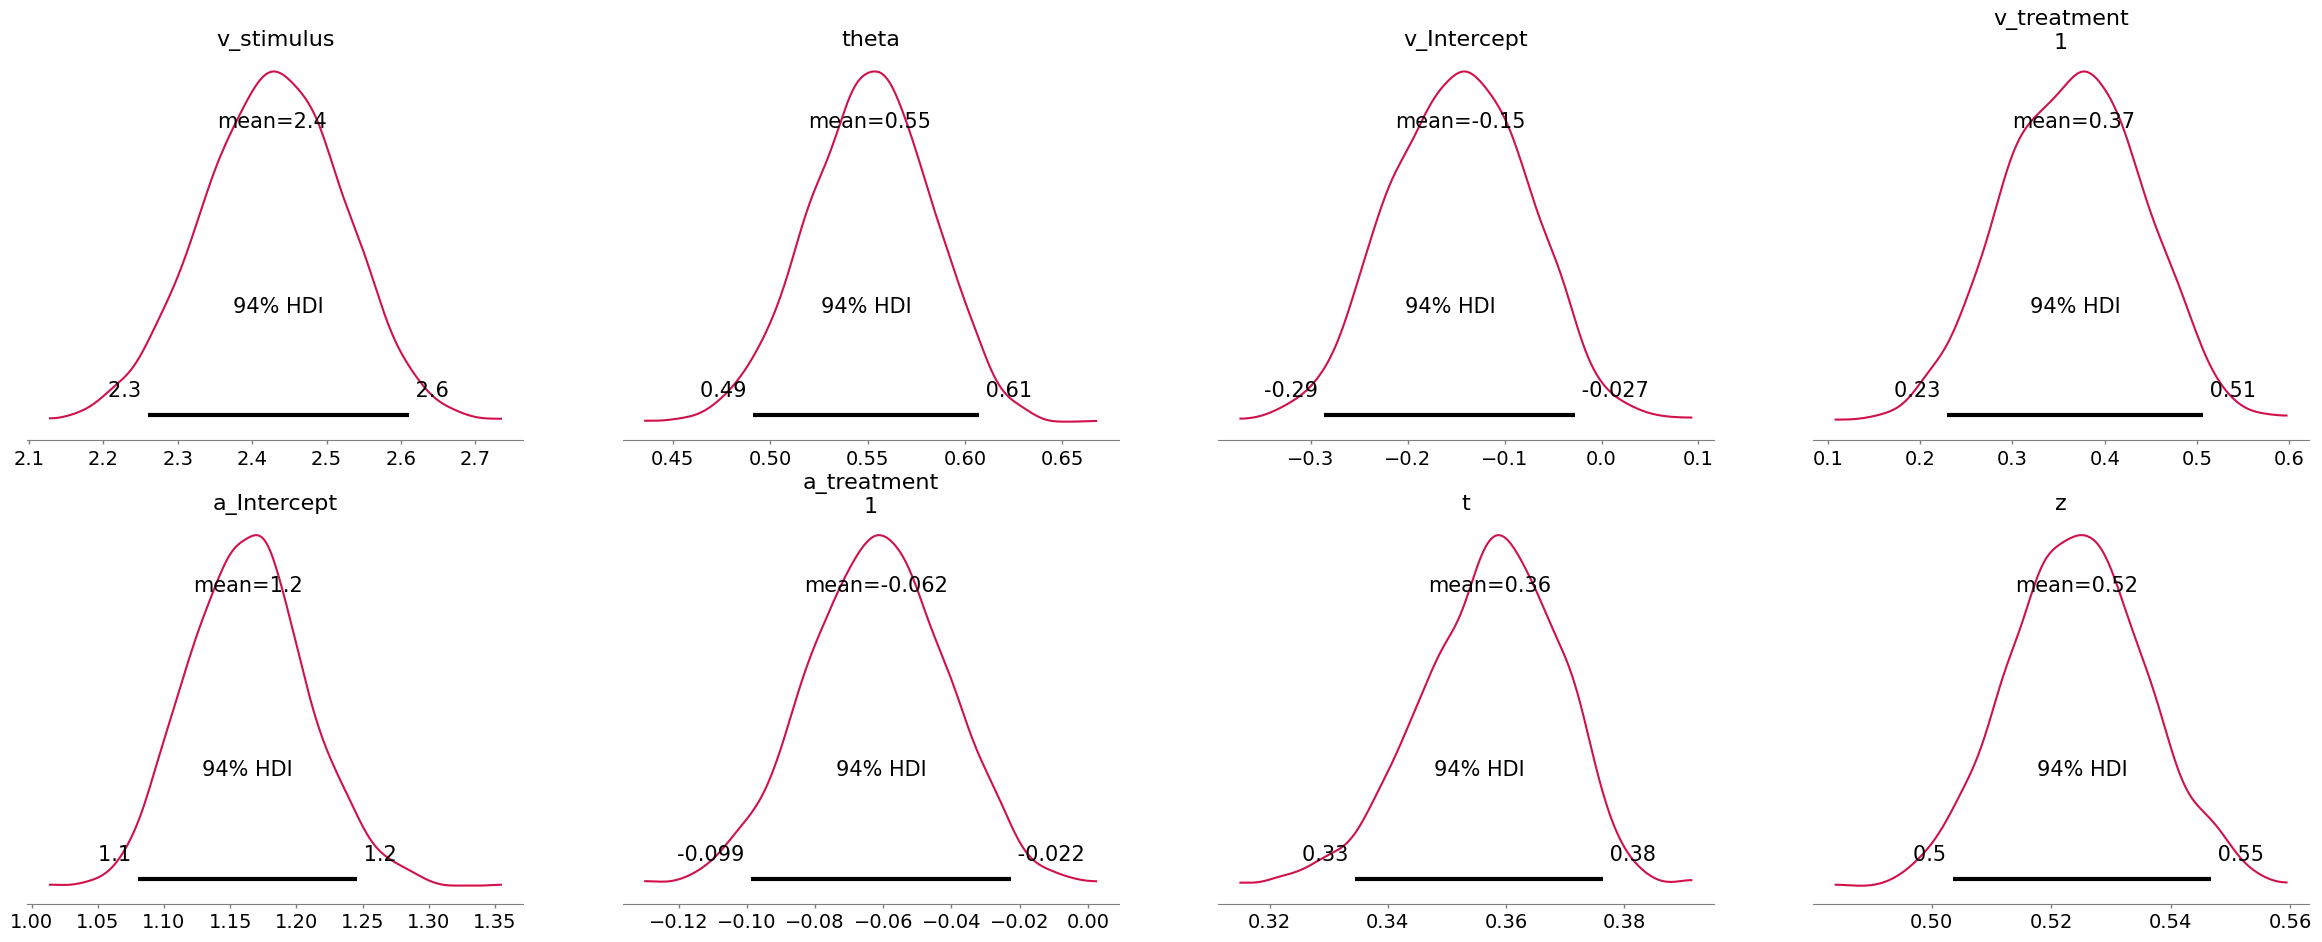

In [9]:
az.plot_posterior(model_reg_v_a.traces)

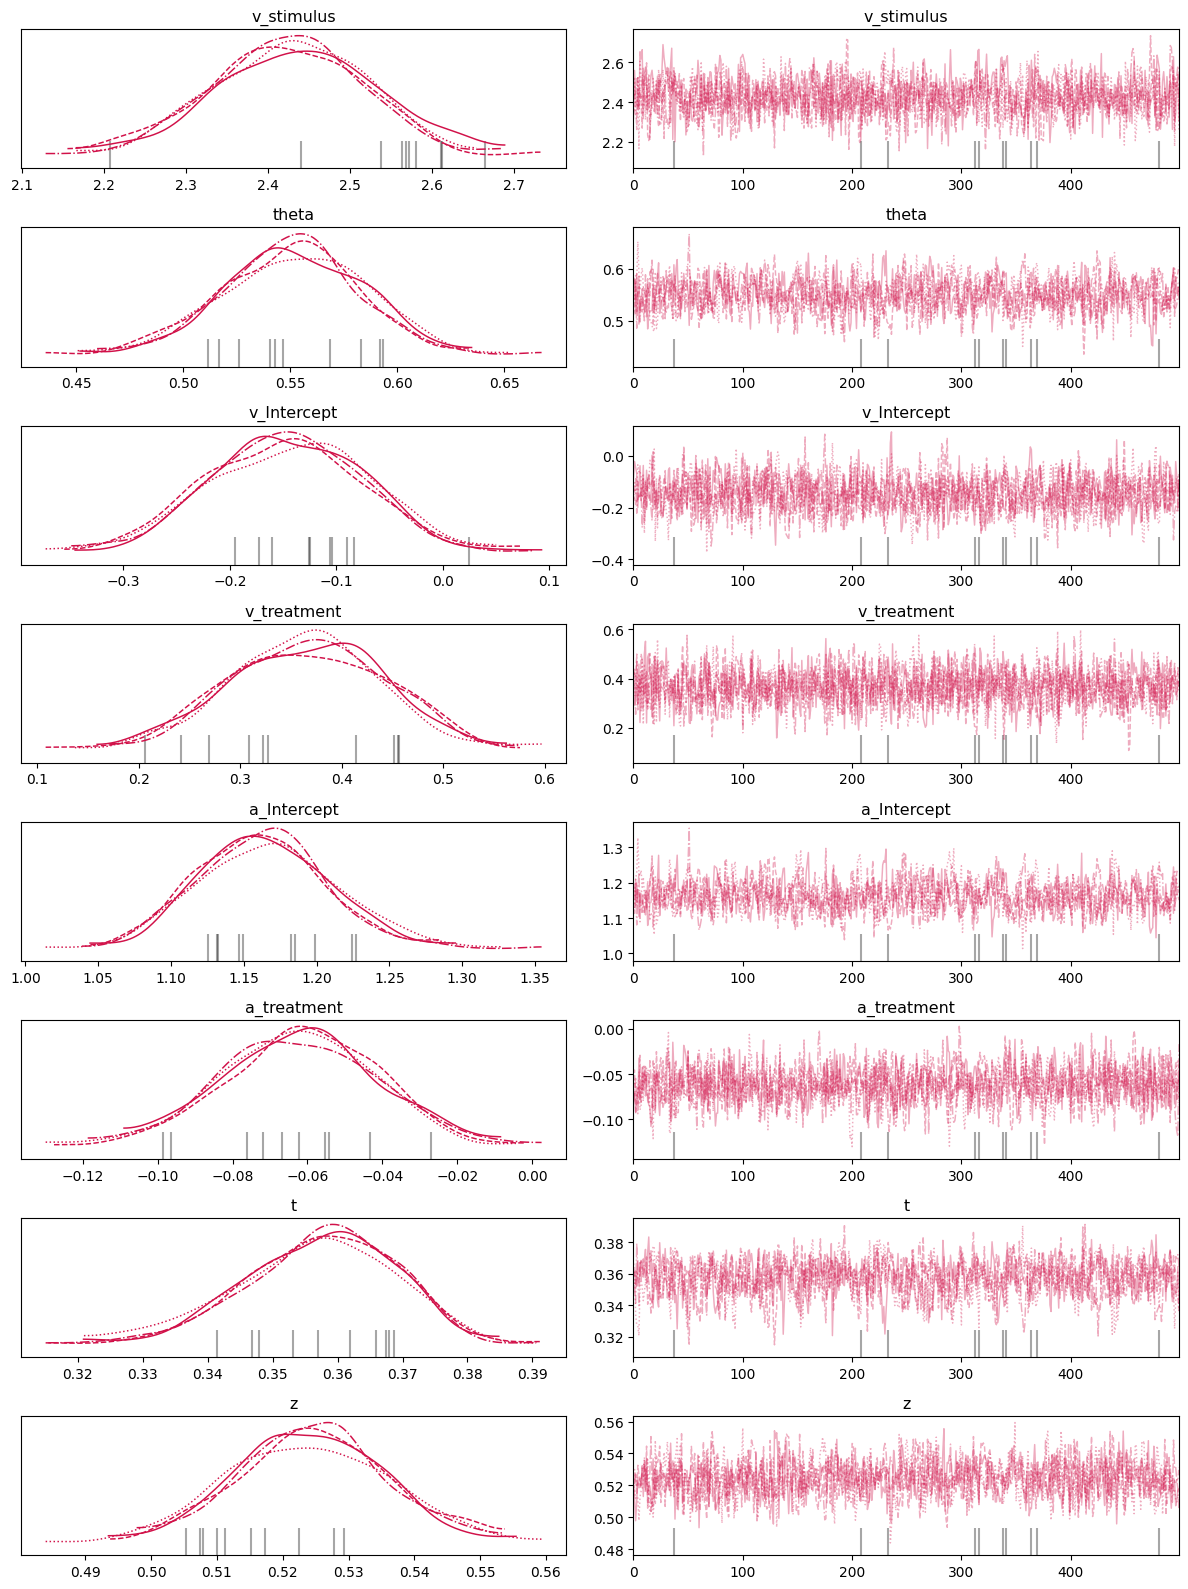

In [10]:
model_reg_v_a.plot_trace()  # Plot the trace of the samples

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


Text(0.5, 1.0, 'Posterior Predictive Plot')

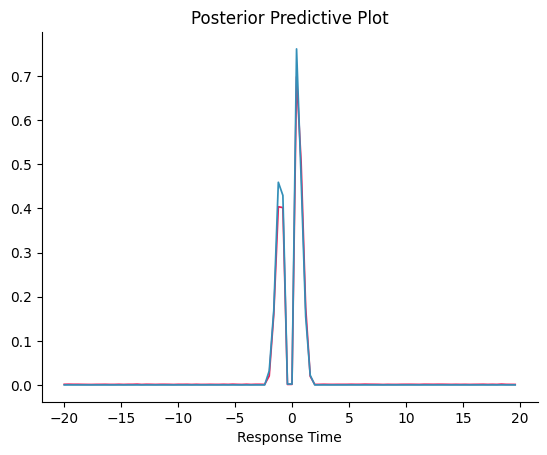

In [11]:
ax = hssm.plotting.plot_posterior_predictive(model_reg_v_a)
sns.despine()
ax.set_ylabel("")
plt.title("Posterior Predictive Plot")

In [12]:
model_data.head()

,rt,response,stimulus,treatment,subject
0,0.626977,1,1.0,0,CG
1,0.945802,-1,0.0,0,CG
2,0.964249,1,-0.0,0,CG
3,0.671215,-1,-1.0,0,CG
4,1.046959,1,0.0,0,CG


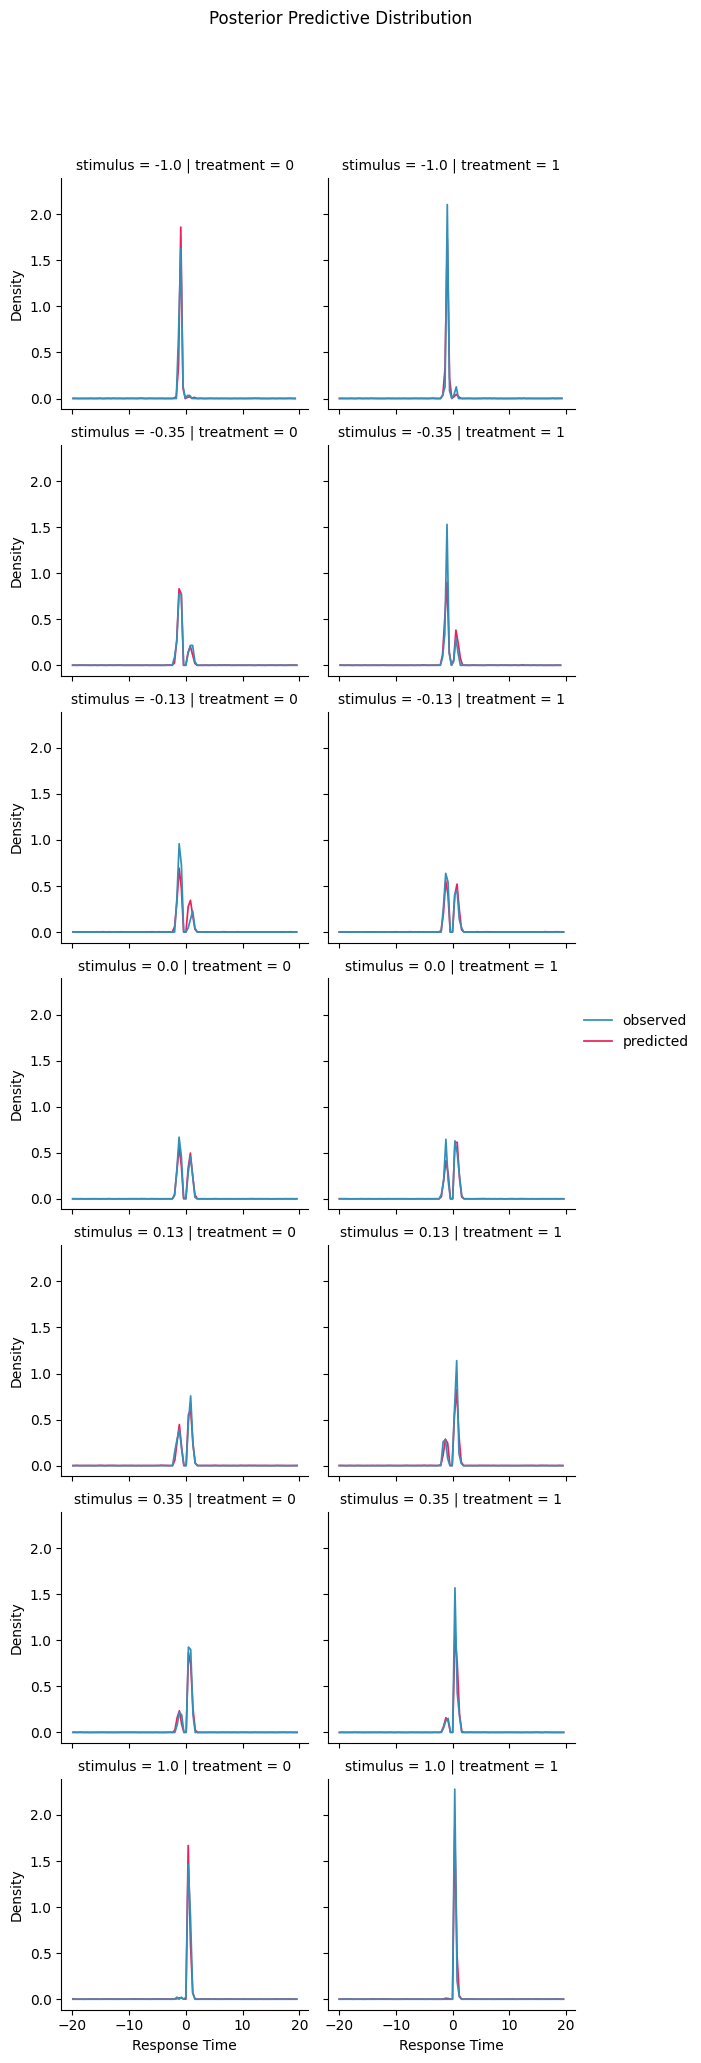

In [13]:
hssm.plotting.plot_posterior_predictive(
    model_reg_v_a,
    col="treatment",
    row="stimulus",
    # row="conf",
)

### Color-Treatment Model

In [14]:
color_model_data = pd.DataFrame(
    {
        "rt": data["reaction_time"]/1000,
        "response": data["choice"],
        "stimulus": data["signed_coherence"]/100,
        "treatment": data["medication"].replace({"off": 0, "on": 1}).astype("category"),
        "color": data["color"].astype("category"),
        "subject": processed_data["subject"],        
    }
)

In [15]:
color_model_data.head()

,rt,response,stimulus,treatment,color,subject
0,0.626977,1,1.0,0,1,CG
1,0.945802,-1,0.0,0,-1,CG
2,0.964249,1,-0.0,0,-1,CG
3,0.671215,-1,-1.0,0,-1,CG
4,1.046959,1,0.0,0,-1,CG


Model initialized successfully.


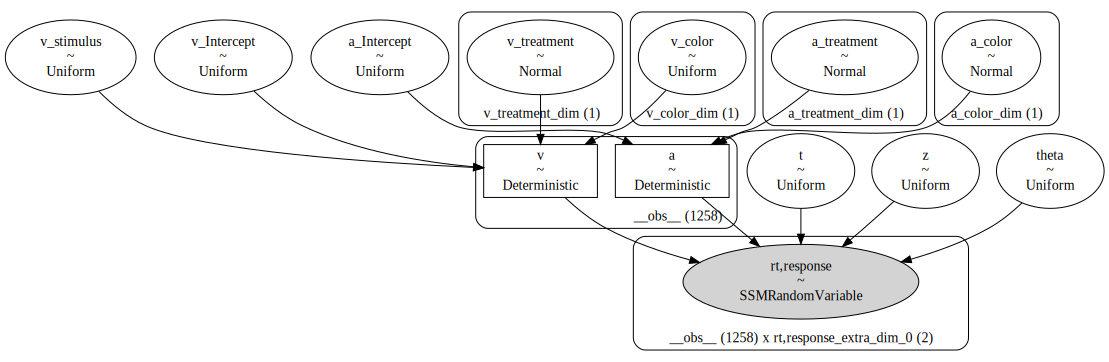

In [16]:
color_treatment_model = hssm.HSSM(
    data=color_model_data.loc[color_model_data["subject"] == subjects[0]],
    model="angle",
    include = [
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "stimulus":  {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "color":  {"name": "Uniform", "lower": -3.0, "upper": 3.0},
            },
            "formula": "v ~ stimulus + treatment + color",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {"Intercept": {"name": "Uniform", "lower": 0.5, "upper": 3.0},},
            "formula": "a ~ treatment + color",
        },
        
    ]
    
)

color_treatment_model.graph()


In [17]:
idata_color_treatment = color_treatment_model.sample(
    sampler="nuts_numpyro", chains=4, cores=4, draws=500, tune=500
) 

Using default initvals. 



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 2000/2000 [00:04<00:00, 494.99it/s]


array([[<Axes: title={'center': 'v_stimulus'}>,
        <Axes: title={'center': 'v_color\n1'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'v_Intercept'}>,
        <Axes: title={'center': 'a_color\n1'}>,
        <Axes: title={'center': 'v_treatment\n1'}>],
       [<Axes: title={'center': 'a_Intercept'}>,
        <Axes: title={'center': 'a_treatment\n1'}>,
        <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >, <Axes: >]], dtype=object)

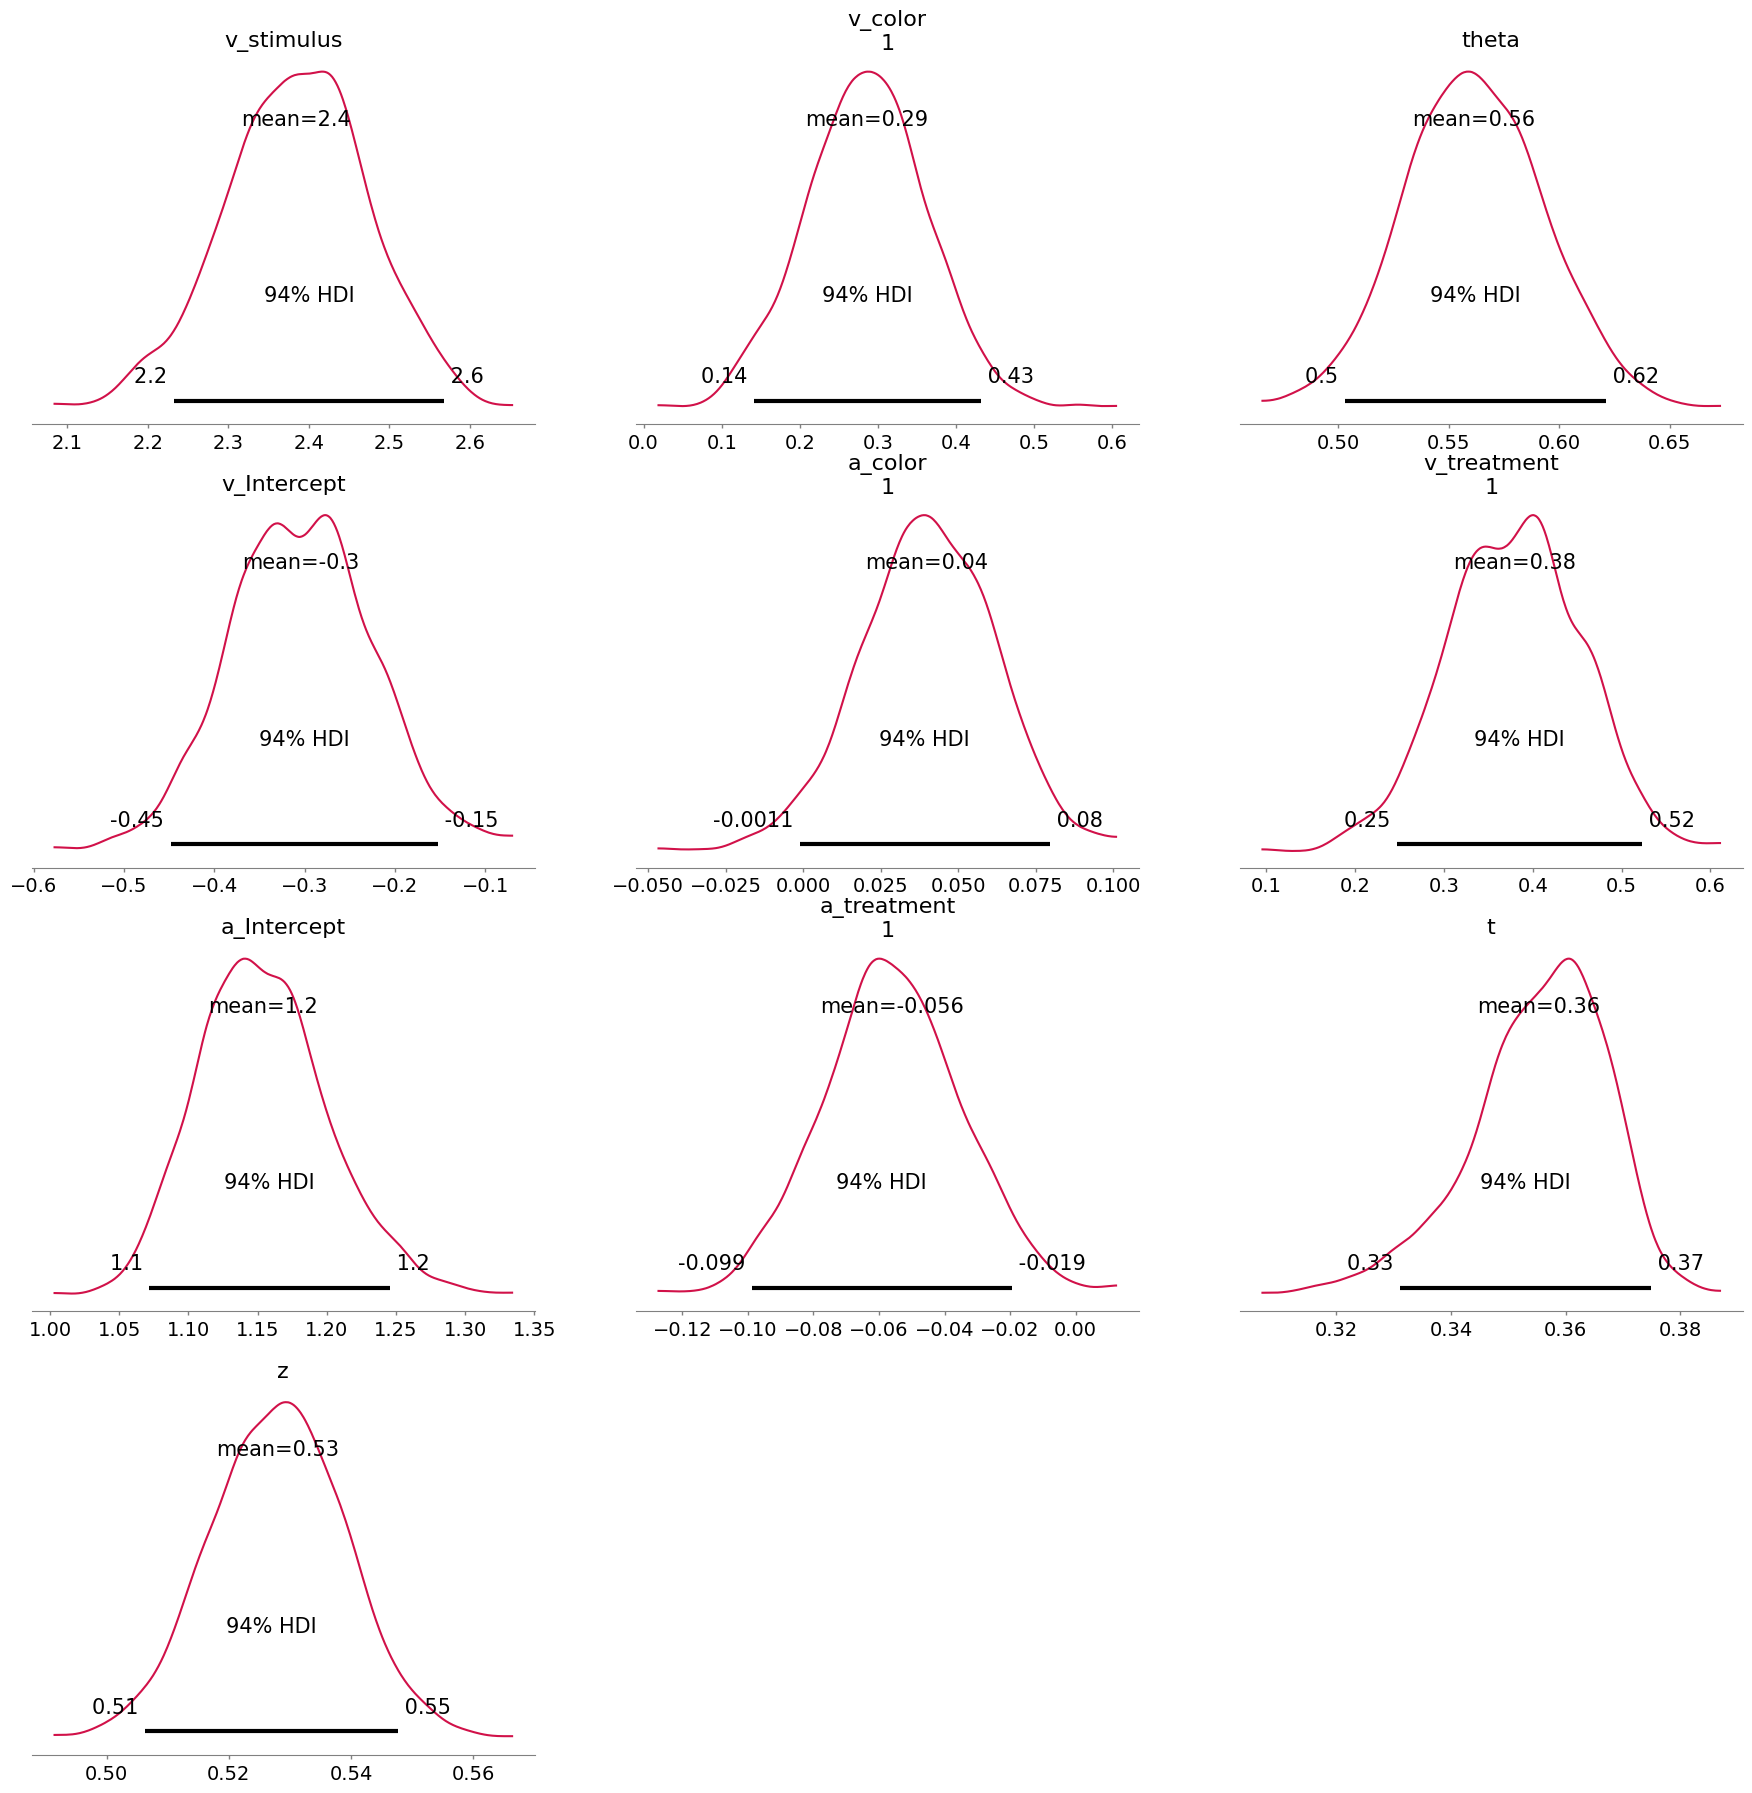

In [18]:
az.plot_posterior(color_treatment_model.traces)

In [19]:
color_treatment_model.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_stimulus,2.385,0.088,2.232,2.568,0.002,0.002,1601.0,1006.0,1.0
a_treatment[1],-0.056,0.021,-0.099,-0.019,0.000,0.000,1959.0,1293.0,1.0
theta,0.561,0.031,0.503,0.621,0.001,0.001,829.0,851.0,1.0
v_Intercept,-0.304,0.079,-0.448,-0.152,0.002,0.002,1418.0,1295.0,1.0
a_color[1],0.040,0.022,-0.001,0.080,0.000,0.000,2002.0,1420.0,1.0
v_treatment[1],0.379,0.075,0.248,0.523,0.002,0.001,1712.0,1119.0,1.0
a_Intercept,1.154,0.047,1.072,1.246,0.002,0.001,818.0,732.0,1.0
v_color[1],0.285,0.077,0.141,0.431,0.002,0.001,1585.0,1486.0,1.0
t,0.355,0.012,0.331,0.375,0.000,0.000,881.0,822.0,1.0
z,0.528,0.011,0.506,0.548,0.000,0.000,924.0,971.0,1.0


No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


Text(0.5, 1.0, 'Posterior Predictive Plot')

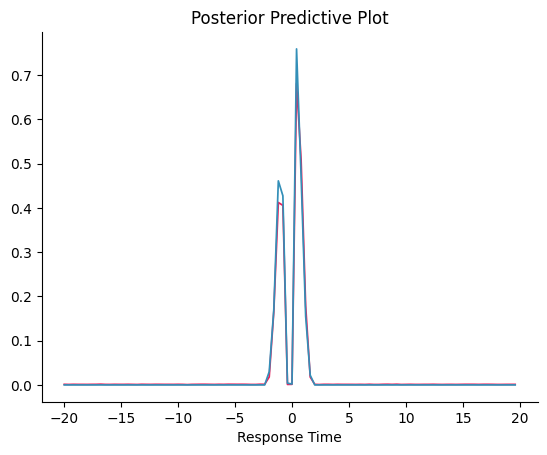

In [20]:
ax = hssm.plotting.plot_posterior_predictive(color_treatment_model)
sns.despine()
ax.set_ylabel("")
plt.title("Posterior Predictive Plot")

In [21]:
stimuli = color_treatment_model.data['stimulus'].unique()
treatments = color_treatment_model.data['treatment'].unique()
colors = color_treatment_model.data['color'].unique()

In [22]:
color_treatment_model.find_MAP()
color_treatment_model.map

Output()

{'theta_interval__': array(-0.12557277, dtype=float32),
 't_interval__': array(-1.5217481, dtype=float32),
 'z_interval__': array(0.14080337, dtype=float32),
 'v_Intercept_interval__': array(0.16235249, dtype=float32),
 'v_stimulus_interval__': array(2.1888332, dtype=float32),
 'v_treatment': array([0.37888458], dtype=float32),
 'v_color_interval__': array([0.19014385], dtype=float32),
 'a_Intercept_interval__': array(-1.0796291, dtype=float32),
 'a_treatment': array([-0.05632783], dtype=float32),
 'a_color': array([0.03966511], dtype=float32),
 'theta': array(0.55610716, dtype=float32),
 't': array(0.3592293, dtype=float32),
 'z': array(0.5281142, dtype=float32),
 'v_Intercept': array(0.24299526, dtype=float32),
 'v_stimulus': array(2.3954535, dtype=float32),
 'v_color': array([0.2843595], dtype=float32),
 'a_Intercept': array(1.1339406, dtype=float32),
 'v': array([ 2.09266353,  2.09266353, -2.69824337, ...,  0.67186313,
        -2.31935879,  2.75590763]),
 'a': array([1.14189544, 1.

In [ ]:
def get_simulated_data(model_name, model):
    model.find_MAP()
    params = {
    "v": model.map['v'],
    "a": model.map['a'], 
    "z": model.map['z'],
    "t": model.map['t'],
    "theta": model.map['theta'],
    }
    simulated_data = hssm.simulate_data(model=model_name, theta=params, size=1)
    return simulated_data

def plot_model_comparison(model, simulated_data):
    observed_data = model.data.copy()
    observed_data.rename(columns={'response': 'choice', 'stimulus': 'signed_coherence'}, inplace=True)
    observed_data['signed_coherence'] = observed_data['signed_coherence'].values*100
    simulated_data['signed_coherence'] = observed_data['signed_coherence'].values
    simulated_data.rename(columns={'response': 'choice'}, inplace=True)
    
    colors_treatments = [(treatment, color) for treatment in treatments for color in colors]
    
    fig, ax = plt.subplots(2, 4, figsize=(20, 10))
    for idx, (treatment, color) in enumerate(colors_treatments):
        print(f"idx: {idx}, color: {color}, treatment: {treatment}")

        subset_idx = np.where((observed_data['treatment'] == treatment) & (observed_data['color'] == color))[0]
        # plot psychometric function
        coh, pf, pf_model, x_hat, y_hat, _ = utils.get_psychometric_data(simulated_data.iloc[subset_idx])
        ax[0, idx].plot(coh, pf, 'o', color='blue')
        ax[0, idx].plot(x_hat, y_hat, color='blue')
        coh, pf, pf_model, x_hat, y_hat, _ = utils.get_psychometric_data(observed_data.iloc[subset_idx])
        ax[0, idx].plot(coh, pf, 'o', color='red')
        ax[0, idx].plot(x_hat, y_hat, color='red')    
        if idx == 0:
                ax[0, idx].set_title(f"Off Medication (Equal Prior)")
        elif idx == 1:
                ax[0, idx].set_title(f"Off Medication (Positive Prior)")   
        elif idx == 2:
                ax[0, idx].set_title(f"On Medication (Equal Prior)")
        else:
                ax[0, idx].set_title(f"On Medication (Positive Prior)")

        ax[1, idx].hist(simulated_data['rt'][subset_idx], bins=25, alpha=0.5, label='simulated', color='blue')
        ax[1, idx].hist(observed_data['rt'].iloc[subset_idx], bins=25, alpha=0.5, label='observed' , color='red')
        ax[1, idx].legend()
    return fig, ax


In [ ]:
params = {
    "v": color_treatment_model.map['v'],
    "a": color_treatment_model.map['a'], 
    "z": color_treatment_model.map['z'],
    "t": color_treatment_model.map['t'],
    "theta": color_treatment_model.map['theta'],
}
simulated_data = hssm.simulate_data(model='angle', theta=params, size=1)

In [24]:
observed_data = color_treatment_model.data.copy()
observed_data.rename(columns={'response': 'choice', 'stimulus': 'signed_coherence'}, inplace=True)
observed_data['signed_coherence'] = observed_data['signed_coherence'].values*100
simulated_data['signed_coherence'] = observed_data['signed_coherence'].values
simulated_data.rename(columns={'response': 'choice'}, inplace=True)

idx: 0, color: -1, treatment: 0
idx: 1, color: 1, treatment: 0
idx: 2, color: -1, treatment: 1
idx: 3, color: 1, treatment: 1


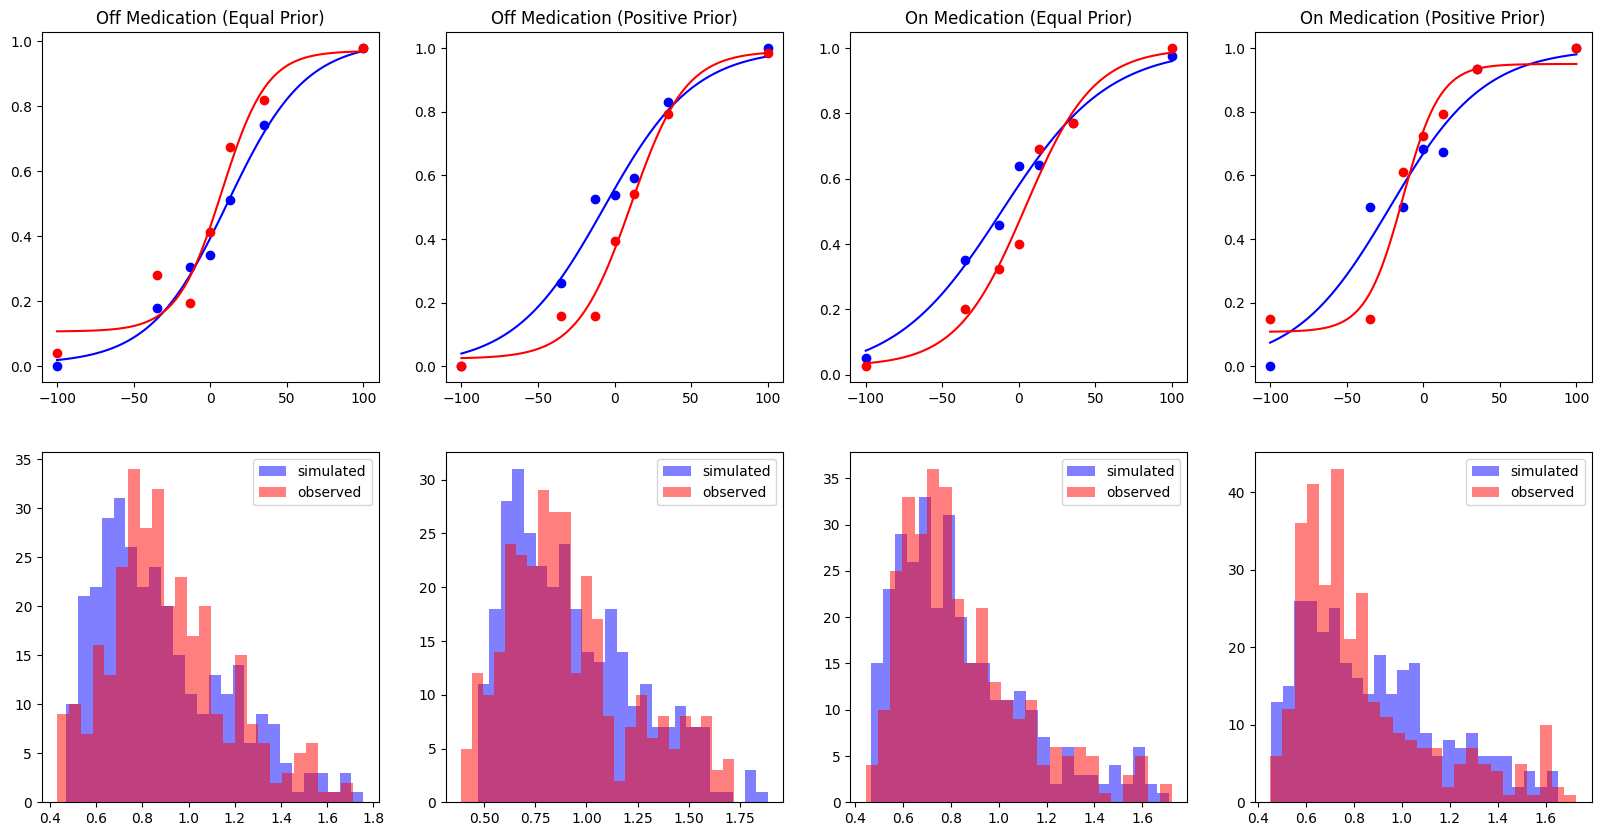

In [ ]:
observed_data = color_treatment_model.data.copy()
observed_data.rename(columns={'response': 'choice', 'stimulus': 'signed_coherence'}, inplace=True)
observed_data['signed_coherence'] = observed_data['signed_coherence'].values*100
simulated_data['signed_coherence'] = observed_data['signed_coherence'].values
simulated_data.rename(columns={'response': 'choice'}, inplace=True)
colors_treatments = [(treatment, color) for treatment in treatments for color in colors]

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for idx, (treatment, color) in enumerate(colors_treatments):
        print(f"idx: {idx}, color: {color}, treatment: {treatment}")
        
        subset_idx = np.where((observed_data['treatment'] == treatment) & (observed_data['color'] == color))[0]
        # plot psychometric function
        coh, pf, pf_model, x_hat, y_hat, _ = utils.get_psychometric_data(simulated_data.iloc[subset_idx])
        ax[0, idx].plot(coh, pf, 'o', color='blue')
        ax[0, idx].plot(x_hat, y_hat, color='blue')
        coh, pf, pf_model, x_hat, y_hat, _ = utils.get_psychometric_data(observed_data.iloc[subset_idx])
        ax[0, idx].plot(coh, pf, 'o', color='red')
        ax[0, idx].plot(x_hat, y_hat, color='red')    
        if idx == 0:
                ax[0, idx].set_title(f"Off Medication (Equal Prior)")
        elif idx == 1:
                ax[0, idx].set_title(f"Off Medication (Positive Prior)")   
        elif idx == 2:
                ax[0, idx].set_title(f"On Medication (Equal Prior)")
        else:
                ax[0, idx].set_title(f"On Medication (Positive Prior)")
        
        
        ax[1, idx].hist(simulated_data['rt'][subset_idx], bins=25, alpha=0.5, label='simulated', color='blue')
        ax[1, idx].hist(observed_data['rt'].iloc[subset_idx], bins=25, alpha=0.5, label='observed' , color='red')
        ax[1, idx].legend()


In [2]:
import jax

print(jax.devices())

[CpuDevice(id=0)]
